# Testing cancelation of SRG transformations in momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ February 9, 2023

The SRG transformations are unitary and therefore satisfy the condition<br>

$$
\begin{align}
U^\dagger U &= I + \frac{1}{4} \sum_{\mathbf{k}, \mathbf{k'}, \mathbf{K}} \bigl[
    \delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'})
    + \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
\bigr]
a^\dagger_{\frac{\mathbf{K}}{2}+\mathbf{k}} a^\dagger_{\frac{\mathbf{K}}{2}-\mathbf{k}}
a_{\frac{\mathbf{K}}{2}-\mathbf{k'}} a_{\frac{\mathbf{K}}{2}+\mathbf{k'}} \\
&= I
.
\end{align}
$$<br>

This implies that<br>

$$
\delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
+ \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
= 0
.
$$<br>

In partial waves this looks like<br>

$$
\delta U_{LL'}(k,k') + \delta U^\dagger_{LL'}(k,k') + \frac{2}{\pi} \sum_{L''} \int dk'' k''^2
    \delta U_{LL''}(k,k'') \delta U^\dagger_{L''L'}(k'',k')
= 0
,
$$<br>
given partial wave channel quantum numbers $J$, $S$, and $T$.<br>

_Last update:_ March 8, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, label_ticks, set_rc_parameters
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.momentum_projection_operator import momentum_projection_operator
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import replace_periods

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Check cancelation of matrix elements

In [4]:
def load_H_evolved(
        kvnn, channel, generator, lamb, kmax=15.0, kmid=3.0, ntot=120,
        solver='ode', method='BDF', atol=1e-10, rtol=1e-10, wrt='s'
):
    """Load evolved Hamiltonian."""
    
    if solver == 'U':
        
        H_file_name = (
            f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax"
            f"_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
            
        H_evolved = np.loadtxt("./test_srg/" + replace_periods(H_file_name)
                               + ".txt")
                
        U_file_name = (
            f"U_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax_{kmax}"
            f"_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
            
        U_evolved = np.loadtxt("./test_srg/" + replace_periods(U_file_name)
                               + ".txt")
        
        return H_evolved, U_evolved
        
    else:
        
        file_name = (
            f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax"
            f"_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
        H_evolved = np.loadtxt("./test_srg/" + replace_periods(file_name)
                               + ".txt")
    
        return H_evolved

In [5]:
kvnn = 6
# kvnn = 111  # SMS N4LO 450 MeV
channel = '3S1'
# channel = '3P1'
# channel = '1P1'
kmax, kmid, ntot = 15.0, 3.0, 120
# kmax, kmid, ntot = 30.0, 4.0, 120  # Different mesh for AV18
generator, lamb = 'Wegner', 1.35
# generator, lamb = 'Wegner', 2.0

potential = Potential(kvnn, channel, kmax, kmid, ntot)
k_array, k_weights = potential.load_mesh()

In [6]:
# Initial and evolved Hamiltonians with integration factors attached [MeV]
H_initial = potential.load_hamiltonian()

In [7]:
# # Get H_evolved from current version generated by srg.py
# H_evolved = potential.load_hamiltonian('srg', generator, lamb)

# # scipy.integrate.ode with BDF solving w.r.t. \lambda
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='ode',
#     method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
# )

# # scipy.integrate.solve_ivp with LSODA solving w.r.t. s
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
#     method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
# )

# Load saved file
H_evolved, U_matrix = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='U', method='BDF',
    atol=1e-10, rtol=1e-10, wrt='lambda'
)

# # SRG transformation with integration factors attached [unitless]
# U_matrix = get_transformation(H_initial, H_evolved)

# Identity matrix
I_matrix = np.eye(len(U_matrix), len(U_matrix))

In [8]:
# \delta U and \delta U^\dagger matrices
delta_U = U_matrix - I_matrix
delta_U_dag = (U_matrix - I_matrix).T

In [9]:
# \delta U 3S1-3S1 sub-block
delta_U_3S1_3S1 = delta_U[:ntot, :ntot]

# \delta U^\dagger 3S1-3S1 sub-block
delta_U_dag_3S1_3S1 = delta_U_dag[:ntot, :ntot]

# \delta U 3S1-3D1 sub-block
delta_U_3S1_3D1 = delta_U[:ntot, ntot:]

# \delta U^\dagger 3D1-3S1 sub-block
delta_U_dag_3D1_3S1 = delta_U_dag[ntot:, :ntot]

In [10]:
# \sum_k'' \delta U_{3S1-3S1}(k,k'') \delta U^\dagger_{3S1-3S1}(k'',k')
delta_U2_3S1_3S1 = delta_U_3S1_3S1 @ delta_U_dag_3S1_3S1

# \sum_k'' \delta U_{3S1-3D1}(k,k'') \delta U^\dagger_{3D1-3S1}(k'',k')
delta_U2_3S1_3D1 = delta_U_3S1_3D1 @ delta_U_dag_3D1_3S1

In [11]:
matrix = delta_U_3S1_3S1 + delta_U_dag_3S1_3S1 + (delta_U2_3S1_3S1
                                                  + delta_U2_3S1_3D1)
print(matrix)
print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[ 5.46737857e-15 -1.24598849e-15 -3.83205581e-15 ... -1.89105711e-15
  -1.34543328e-15 -4.11296826e-16]
 [-1.24598849e-15 -7.51640893e-15 -3.07732543e-14 ... -1.51783372e-14
  -1.08027549e-14 -3.30227952e-15]
 [-3.83205581e-15 -3.07732543e-14 -4.64132197e-14 ... -4.65602695e-14
  -3.31980597e-14 -1.01472417e-14]
 ...
 [-1.89105711e-15 -1.51783372e-14 -4.65602695e-14 ... -2.53973428e-08
  -2.88195255e-08 -1.75963354e-08]
 [-1.34543328e-15 -1.08027549e-14 -3.31980597e-14 ... -2.88195255e-08
  -3.71369376e-08 -2.34160754e-08]
 [-4.11296826e-16 -3.30227952e-15 -1.01472417e-14 ... -1.75963354e-08
  -2.34160754e-08 -1.49363669e-08]]
Norm of matrix with integration weights = 0.00000.

Norm of matrix without integration weights = 0.00000.



In [12]:
def plot_delU_sum(
        k_array, matrix_no_weights, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,4.0),
        xlabel_size=16, ylabel_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # We don't need the second output since it'll be the same as the first
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
    k_array_dense, _, matrix_dense = interpolate_matrix(
        k_array, k_array, matrix_no_weights, k_max, k_max)

    # --- Plot --- #
    c = ax.contourf(k_array_dense, k_array_dense, matrix_dense, levels,
                    cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title(r"[fm$^3$]", fontsize=16, pad=15)

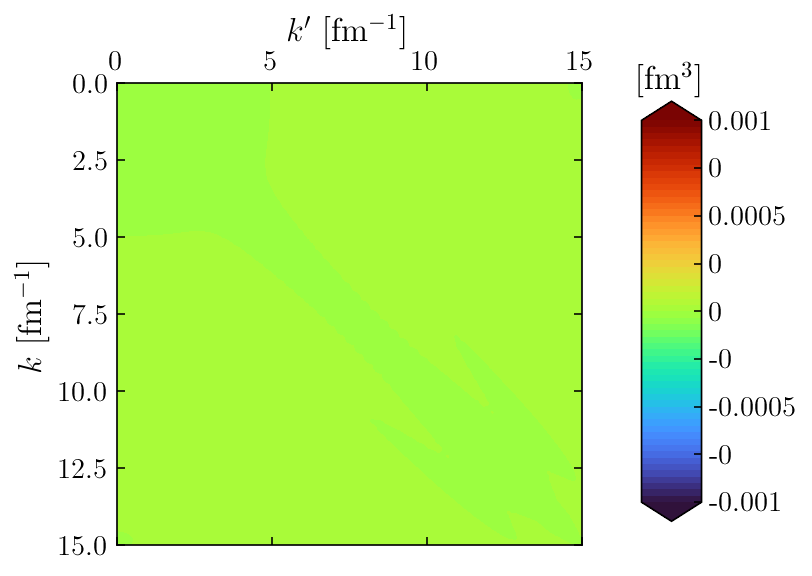

In [13]:
plot_delU_sum(
    k_array, matrix_no_weights, colorbar_limits=(-0.001,0.001),
    axes_limits=(0.0,15.0), xlabel_size=16, ylabel_size=16
)

The above plot shows
$$
\delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
+ \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
$$
where integration factors have been divided out.

In [14]:
# delta_U_3S1_3S1_no_weights = unattach_weights_from_matrix(k_array, k_weights,
#                                                           delta_U_3S1_3S1)
# delta_U_dag_3S1_3S1_no_weights = unattach_weights_from_matrix(
#     k_array, k_weights, delta_U_dag_3S1_3S1
# )
# delta_U_linear = delta_U_3S1_3S1_no_weights + delta_U_dag_3S1_3S1_no_weights

In [15]:
# plot_delU_sum(
#     k_array, delta_U_3S1_3S1_no_weights, colorbar_limits=(-0.5,0.5),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [16]:
# plot_delU_sum(
#     k_array, delta_U_dag_3S1_3S1_no_weights, colorbar_limits=(-0.5,0.5),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [17]:
# plot_delU_sum(
#     k_array, delta_U_linear, colorbar_limits=(-0.5,0.5), axes_limits=(0.0,4.0),
#     xlabel_size=16, ylabel_size=16
# )

In [18]:
# delta_U2_no_weights = unattach_weights_from_matrix(
#     k_array, k_array, 1/2*(delta_U2_3S1_3S1 + delta_U2_3S1_3D1)
# )

# plot_delU_sum(
#     k_array, delta_U2_no_weights, colorbar_limits=(-0.1,0.1),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [19]:
# print((I_matrix+delta_U) @ (I_matrix+delta_U).T)

In [20]:
# print(I_matrix @ I_matrix + delta_U @ I_matrix + I_matrix @ delta_U_dag + delta_U @ delta_U_dag)

In [21]:
# print(delta_U @ I_matrix + I_matrix @ delta_U_dag + delta_U @ delta_U_dag)

## Check that normalization of momentum projection operator is conserved

In [22]:
q = 2.0
mpo_initial = momentum_projection_operator(
    q, k_array, k_weights, coupled=potential.coupled_channel_bool
)

print(f"Unevolved norm = {la.norm(mpo_initial)}")

mpo_I_matrix = I_matrix @ mpo_initial @ I_matrix
mpo_delU_matrix = delta_U @ mpo_initial @ I_matrix
mpo_delUdag_matrix = I_matrix @ mpo_initial @ delta_U_dag
mpo_delU2_matrix = delta_U @ mpo_initial @ delta_U_dag

mpo_evolved = (mpo_I_matrix + mpo_delU_matrix + mpo_delUdag_matrix
               + mpo_delU2_matrix)

print(f"Evolved norm = {la.norm(mpo_evolved)}")

Unevolved norm = 2.847882658769522
Evolved norm = 2.8478826478270873


## Cancelation after interpolating $\delta U$ functions

In [23]:
# # Check that \delta U_{3S1-3S1} * \delta U^\dagger_{3S1-3S1} is equal to
# # \delta U_{3S1-3S1}^2

# delU_3S1_3S1 = unattach_weights_from_matrix(k_array, k_weights, delta_U_3S1_3S1)

# delUdag_3S1_3S1 = unattach_weights_from_matrix(k_array, k_weights,
#                                                delta_U_dag_3S1_3S1)

# product = np.zeros_like(delU_3S1_3S1)
# for i in range(ntot):
#     for j in range(ntot):
#         product[i,j] = delU_3S1_3S1[i,j] * delUdag_3S1_3S1[j,i]

# print(delU_3S1_3S1**2-product)

In [24]:
# # Do the same test for the 3S1-3D1 block
# delU_3S1_3D1 = unattach_weights_from_matrix(k_array, k_weights, delta_U_3S1_3D1)
# delUdag_3D1_3S1 = unattach_weights_from_matrix(k_array, k_weights,
#                                                delta_U_dag_3D1_3S1)

# product = np.zeros_like(delU_3S1_3D1)
# for i in range(ntot):
#     for j in range(ntot):
#         product[i,j] = delU_3S1_3D1[i,j] * delUdag_3D1_3S1[j,i]
        
# print(delU_3S1_3D1**2-product)

In [25]:
# COPIED FROM compare_to_lda.ipynb
def interpolate_delta_U(
        potential, channel, generator='Wegner', lamb=1.35,
        hermitian_conjugate=False, order=3
):
    """Function that returns interpolated \delta U(k, k'),
    \delta U^\dagger(k, k') or \delta U^2(k, k') given the partial wave channel.
    """
    
    kmax, kmid, ntot = potential.kmax, potential.kmid, potential.ntot
    
    # Get momentum mesh
    # k_array, k_weights = potential.load_mesh()
    # ntot = potential.ntot
    k_array, k_weights = momentum_mesh(kmax, kmid, ntot)

    # Initial Hamiltonian
    H_initial = potential.load_hamiltonian()
    
#     # Evolved Hamiltonian
#     H_evolved = potential.load_hamiltonian('srg', generator, lamb)

    # scipy.integrate.solve_ivp with LSODA solving w.r.t. s
    if channel[:3] == '3S1' or channel[:3] == '3D1':
#         H_evolved = load_H_evolved(
#             potential.kvnn, '3S1', generator, lamb, kmax, kmid, ntot,
#             solver='solve_ivp', method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
#         )
        H_evolved, U_matrix_weights = load_H_evolved(
            potential.kvnn, '3S1', generator, lamb, kmax, kmid, ntot,
            solver='U', method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
        )
    else:
#         H_evolved = load_H_evolved(
#             potential.kvnn, channel, generator, lamb, kmax, kmid, ntot,
#             solver='solve_ivp', method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
#         )
        H_evolved, U_matrix_weights = load_H_evolved(
            potential.kvnn, channel, generator, lamb, kmax, kmid, ntot,
            solver='U', method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
        )
    
#     # Get SRG transformation from Hamiltonians
#     U_matrix_weights = get_transformation(H_initial, H_evolved)
    
    # Calculate \delta U = U - I
    I_matrix_weights = np.eye(len(H_initial), len(H_initial))
    if hermitian_conjugate:
        delU_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    else:
        delU_matrix_weights = U_matrix_weights - I_matrix_weights

    # Get specific sub-block if coupled-channel
    if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,ntot:])
    elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,:ntot])
    elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,ntot:])
    else:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,:ntot])
        
    # Interpolate \delta U(k, k') or \delta U^\dagger(k, k')
    delU_func = RectBivariateSpline(k_array, k_array, delU_matrix, kx=order,
                                    ky=order)
#     delU_func = RegularGridInterpolator((k_array, k_array), delU_matrix,
#                                         method='nearest')
    
    return delU_func

In [26]:
# COPIED FROM compare_to_lda.ipynb
def get_delta_U_functions(potential, channel, order=3):
    
    if channel == '3S1':
        channels = ('3S1-3S1', '3S1-3D1', '3D1-3S1')
    else:
        channels = [channel]

    delta_U_functions = {}
    delta_U_dagger_functions = {}
    for ichannel in channels:
        delta_U_functions[ichannel] = interpolate_delta_U(potential, ichannel,
                                                          order=order)
        delta_U_dagger_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, hermitian_conjugate=True, order=order
        )

    return delta_U_functions, delta_U_dagger_functions

In [27]:
# Create a Gaussian quadrature array from max/min of the default array, but with
# no kmid, and less points.
k_array_new, k_weights_new = gaussian_quadrature_mesh(k_array[-1], 100)
# k_array_new, k_weights_new = gaussian_quadrature_mesh(k_array[-1], 500,
#                                                       xmin=k_array[0])
# k_array_new, k_weights_new = k_array, k_weights

k_2d_grid, kp_2d_grid = np.meshgrid(k_array_new, k_array_new, indexing='ij')
k_3d_grid, kpp_3d_grid, kp_3d_grid = np.meshgrid(k_array_new, k_array_new,
                                                 k_array_new, indexing='ij')
_, dkpp_3d_grid, _ = np.meshgrid(
    k_array_new, 2/np.pi*k_weights_new * k_array_new**2, k_array_new,
    indexing='ij'
)

In [28]:
# Call interpolated functions and create new arrays

# delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
#     potential, channel, order=1)  # Linear
delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
    potential, channel, order=3)  # Cubic
# delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
#     potential, channel, order=5)  # Quintic

# Use this code for RectBivariateSpline
deltaU_3S1_3S1 = delta_U_functions['3S1-3S1'].ev(k_2d_grid, kp_2d_grid)
deltaUdag_3S1_3S1 = delta_U_dagger_functions['3S1-3S1'].ev(k_2d_grid, kp_2d_grid)

deltaU2 = np.sum(
    (
        delta_U_functions['3S1-3S1'].ev(k_3d_grid, kpp_3d_grid)
        * delta_U_dagger_functions['3S1-3S1'].ev(kpp_3d_grid, kp_3d_grid)
        + delta_U_functions['3S1-3D1'].ev(k_3d_grid, kpp_3d_grid)
        * delta_U_dagger_functions['3D1-3S1'].ev(kpp_3d_grid, kp_3d_grid)
    ) * dkpp_3d_grid,
    axis=1
)

# # Use this code for RegularGridInterpolator
# deltaU_3S1_3S1 = delta_U_functions['3S1-3S1']((k_2d_grid, kp_2d_grid))
# deltaUdag_3S1_3S1 = delta_U_dagger_functions['3S1-3S1']((k_2d_grid, kp_2d_grid))

# deltaU2 = np.sum(
#     (
#         delta_U_functions['3S1-3S1']((k_3d_grid, kpp_3d_grid))
#         * delta_U_dagger_functions['3S1-3S1']((kpp_3d_grid, kp_3d_grid))
#         + delta_U_functions['3S1-3D1']((k_3d_grid, kpp_3d_grid))
#         * delta_U_dagger_functions['3D1-3S1']((kpp_3d_grid, kp_3d_grid))
#     ) * dkpp_3d_grid,
#     axis=1
# )

In [29]:
# Repeat the steps from above
matrix_no_weights = deltaU_3S1_3S1 + deltaUdag_3S1_3S1 + deltaU2
print(matrix_no_weights)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[ 1.08593044e-06 -1.61019898e-07  3.41134028e-08 ...  5.44200751e-09
  -5.03618908e-11 -1.91465043e-09]
 [-1.61019898e-07  7.52695315e-08  2.45301079e-08 ...  5.38905107e-09
  -8.51811544e-11 -1.94383738e-09]
 [ 3.41134028e-08  2.45301078e-08  3.18947728e-08 ...  5.33979203e-09
  -1.15953756e-10 -1.96916858e-09]
 ...
 [ 5.44200751e-09  5.38905107e-09  5.33979203e-09 ... -6.67902733e-04
  -3.85785012e-04 -3.11901368e-04]
 [-5.03618908e-11 -8.51811544e-11 -1.15953756e-10 ... -3.85785012e-04
  -2.06247049e-04 -1.62381140e-04]
 [-1.91465043e-09 -1.94383738e-09 -1.96916858e-09 ... -3.11901368e-04
  -1.62381140e-04 -1.26622409e-04]]
Norm of matrix without integration weights = 0.00826.



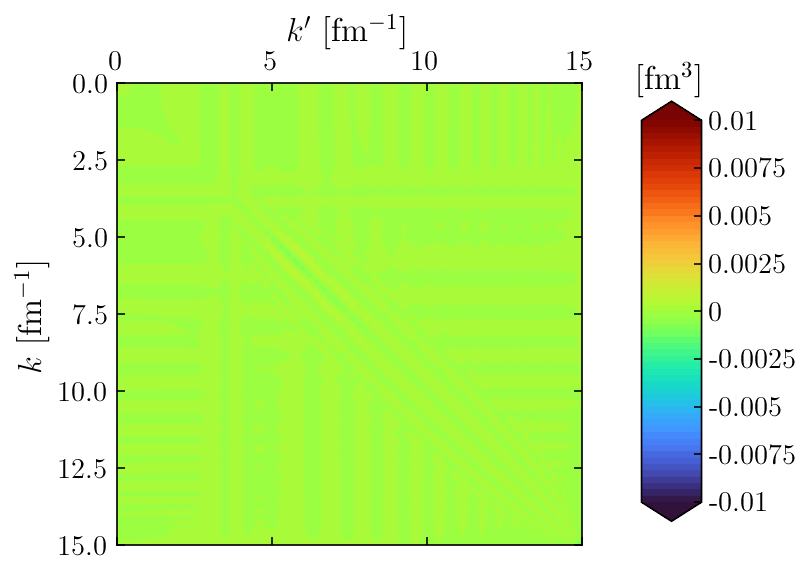

In [30]:
plot_delU_sum(
    k_array_new, matrix_no_weights, colorbar_limits=(-0.01,0.01),
    axes_limits=(0.0,15.0), xlabel_size=16, ylabel_size=16
)

Normalization of cancelation matrix (matrix that should be entirely zero):<br>
* Linear `RectBivariateSpline`: 0.04434
* Cubic `RectBivariateSpline`: 0.01108
* Quintic `RectBivariateSpline`: 0.13699
* Nearest `RegularGridInterpolator`: 0.14537

## Repeating the same tests as above but for $^{1}S_0$

In [31]:
kvnn = 6
channel = '1S0'
kmax, kmid, ntot = 15.0, 3.0, 120
generator, lamb = 'Wegner', 1.35

potential = Potential(kvnn, channel, kmax, kmid, ntot)
k_array, k_weights = potential.load_mesh()

In [32]:
# Initial and evolved Hamiltonians with integration factors attached [MeV]
H_initial = potential.load_hamiltonian()

In [33]:
# H_evolved = potential.load_hamiltonian('srg', generator, lamb)

# # scipy.integrate.ode with BDF solving w.r.t. \lambda
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='ode',
#     method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
# )

# scipy.integrate.solve_ivp with LSODA solving w.r.t. s
H_evolved = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
    method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
)

# SRG transformation with integration factors attached [unitless]
U_matrix = get_transformation(H_initial, H_evolved)

# Identity matrix
I_matrix = np.eye(len(U_matrix), len(U_matrix))

In [34]:
# \delta U and \delta U^\dagger matrices
delta_U = U_matrix - I_matrix
delta_U_dag = (U_matrix - I_matrix).T

In [35]:
# \sum_k'' \delta U(k,k'') \delta U^\dagger(k'',k')
delta_U2 = delta_U @ delta_U_dag

In [36]:
matrix = delta_U + delta_U_dag + delta_U2
print(matrix)
print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[-7.42127379e-16  1.25087805e-17 -4.25782121e-18 ...  1.14142653e-18
  -2.90783102e-18 -2.84908962e-18]
 [ 1.25087805e-17 -2.78983351e-15 -1.33749912e-15 ...  2.89028023e-17
   1.74785884e-16  1.22751671e-16]
 [-4.25782121e-18 -1.33749912e-15 -6.22568369e-16 ... -1.04943676e-17
   1.16396091e-17  8.45876218e-17]
 ...
 [ 1.14142653e-18  2.89028023e-17 -1.04943676e-17 ...  2.77555756e-16
  -4.71844785e-16 -8.60422844e-16]
 [-2.90783102e-18  1.74785884e-16  1.16396091e-17 ... -4.71844785e-16
   3.33066907e-16  1.66533454e-16]
 [-2.84908962e-18  1.22751671e-16  8.45876218e-17 ... -8.60422844e-16
   1.66533454e-16  2.91433544e-16]]
Norm of matrix with integration weights = 0.00000.

Norm of matrix without integration weights = 0.00000.



In [37]:
# Create a Gaussian quadrature array from max/min of the default array, but with
# no kmid, and less points
k_array_new, k_weights_new = gaussian_quadrature_mesh(k_array[-1], 100)

k_2d_grid, kp_2d_grid = np.meshgrid(k_array_new, k_array_new, indexing='ij')
k_3d_grid, kpp_3d_grid, kp_3d_grid = np.meshgrid(k_array_new, k_array_new,
                                                 k_array_new, indexing='ij')
_, dkpp_3d_grid, _ = np.meshgrid(
    k_array_new, 2/np.pi*k_weights_new * k_array_new**2, k_array_new,
    indexing='ij'
)

In [38]:
# Call interpolated functions and create new arrays

delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
    potential, channel, order=3)  # Cubic

# Use this code for RectBivariateSpline
deltaU_1S0 = delta_U_functions['1S0'].ev(k_2d_grid, kp_2d_grid)
deltaUdag_1S0 = delta_U_dagger_functions['1S0'].ev(k_2d_grid, kp_2d_grid)

deltaU2_1S0 = np.sum((delta_U_functions['1S0'].ev(k_3d_grid, kpp_3d_grid)
    * delta_U_dagger_functions['1S0'].ev(kpp_3d_grid, kp_3d_grid))
    * dkpp_3d_grid, axis=1
)

# # Use this code for RegularGridInterpolator
# deltaU_1S0 = delta_U_functions['1S0']((k_2d_grid, kp_2d_grid))
# deltaUdag_1S0 = delta_U_dagger_functions['1S0']((k_2d_grid, kp_2d_grid))

# deltaU2_1S0 = np.sum((delta_U_functions['1S0']((k_3d_grid, kpp_3d_grid))
#     * delta_U_dagger_functions['1S0']((kpp_3d_grid, kp_3d_grid)))
#     * dkpp_3d_grid, axis=1
# )

In [39]:
# Repeat the steps from above
matrix_no_weights = deltaU_1S0 + deltaUdag_1S0 + deltaU2_1S0
print(matrix_no_weights)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[ 9.07315786e-06 -1.60612652e-06  7.97534395e-08 ... -1.97987203e-08
   2.20768220e-08 -1.87005944e-08]
 [-1.60612652e-06  2.88701771e-07 -6.76220253e-09 ... -1.98017687e-08
   2.20783601e-08 -1.87033618e-08]
 [ 7.97534395e-08 -6.76220253e-09  1.06565501e-08 ... -1.97834574e-08
   2.20562802e-08 -1.86859668e-08]
 ...
 [-1.97987203e-08 -1.98017687e-08 -1.97834574e-08 ...  9.72026453e-04
   9.89155983e-04  8.45412395e-04]
 [ 2.20768220e-08  2.20783601e-08  2.20562802e-08 ...  9.89155983e-04
   8.96507356e-04  8.44851590e-04]
 [-1.87005944e-08 -1.87033618e-08 -1.86859668e-08 ...  8.45412395e-04
   8.44851590e-04  7.19202904e-04]]
Norm of matrix without integration weights = 0.01003.



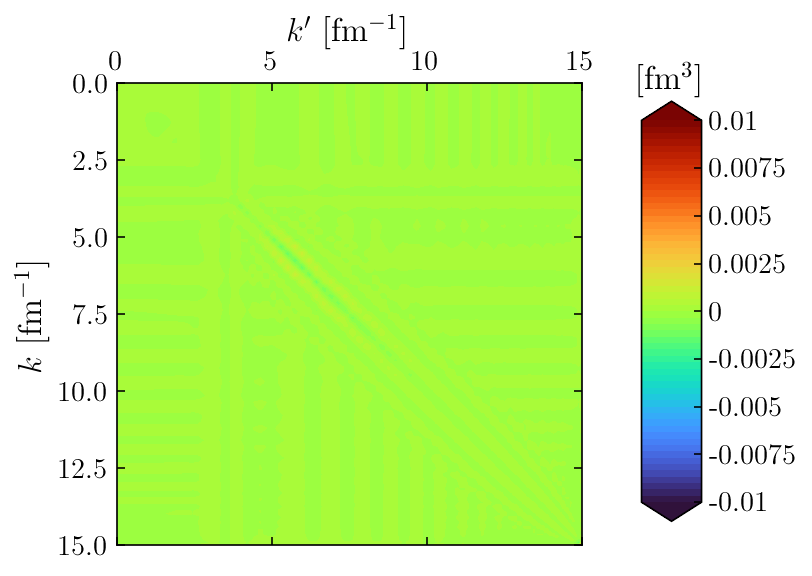

In [40]:
plot_delU_sum(
    k_array_new, matrix_no_weights, colorbar_limits=(-0.01,0.01),
    axes_limits=(0.0,15.0), xlabel_size=16, ylabel_size=16
)

Normalization of cancelation matrix (matrix that should be entirely zero):<br>
* Nearest `RegularGridInterpolator`: 0.15482

In [41]:
# Is the U(k, k') defined on the new k_array even unitary?
from scripts.integration import attach_weights_to_matrix

delU_matrix_weights_new = attach_weights_to_matrix(k_array_new, k_weights_new,
                                                   deltaU_1S0)

ntot_new = len(k_array_new)
I_matrix = np.eye(ntot_new, ntot_new)
U = I_matrix + delU_matrix_weights_new
zero_matrix = I_matrix - U @ U.T

In [42]:
print(zero_matrix)
print(la.norm(I_matrix - U @ U.T)/np.sqrt(ntot_new))
print(la.norm(I_matrix)/np.sqrt(ntot_new))
print(la.norm(U @ U.T)/np.sqrt(ntot_new))

[[-1.46549439e-13  2.08489802e-13 -3.18695293e-14 ...  4.26300339e-12
  -3.79776832e-12  2.11021879e-12]
 [ 2.08489802e-13 -3.01314529e-13  2.17137327e-14 ...  3.42612043e-11
  -3.05195978e-11  1.69594528e-11]
 [-3.18695293e-14  2.17137327e-14 -1.05471187e-13 ...  1.05371217e-10
  -9.38567318e-11  5.21589567e-11]
 ...
 [ 4.26300339e-12  3.42612043e-11  1.05371217e-10 ... -2.78965321e-03
  -2.26803770e-03 -1.27155240e-03]
 [-3.79776832e-12 -3.05195978e-11 -9.38567318e-11 ... -2.26803770e-03
  -1.64230078e-03 -1.01521829e-03]
 [ 2.11021879e-12  1.69594528e-11  5.21589567e-11 ... -1.27155240e-03
  -1.01521829e-03 -5.66905412e-04]]
0.006465598713160874
1.0
0.9972400832488584
